This notebook tries to search for optimal fixed policies (e.g. constant mortality) that maximize the objective (i.e. expected net reward). Here I try [scikit-optimize](https://scikit-optimize.github.io/stable/index.html).

# Setup
---

In [2]:
# %pip install -e ..
# %pip install scikit-optimize

In [1]:
import numpy as np
import pandas as pd
import ray

from skopt import gp_minimize, gbrt_minimize 
from skopt import dump
from skopt.plots import plot_objective, plot_convergence
from skopt.space import Real
from skopt.utils import use_named_args

from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

from rl4fisheries import AsmEnv, Msy, ConstEsc, CautionaryRule
from rl4fisheries.envs.asm_fns import get_r_devs, observe_total

ModuleNotFoundError: No module named 'rl4fisheries'

In [2]:
# CONFIG = {"s":  0.86, "noiseless": False, "testing_harvs": False}
CONFIG = {
    'observation_fn_id': 'observe_1o', 
    'n_observs': 1, 
    'wrong_harv_vul': False,
}

## Hugging face login

In [4]:
## download & upload saved model weights
from huggingface_hub import hf_hub_download, HfApi, login
api = HfApi()
login()

# Policy Optimization
---

## Policy evaluation fn

In [15]:
@ray.remote
def generate_rew(policy, env_cls, config):
    ep_rew = 0
    env = env_cls(config=config)
    obs, info = env.reset()
    for t in range(env.Tmax):
        act, info = policy.predict(obs)
        obs, rew, term, trunc, info = env.step(act)
        ep_rew += rew
    return ep_rew


def rew_batch(policy, env_cls, config, batch_size):
    tmax = env_cls().Tmax
    parallel = [generate_rew.remote(policy, env_cls, config) for _ in range(batch_size)]
    rews = ray.get(parallel)
    if ray.is_initialized():
        ray.shutdown()
    return rews

def eval_pol(policy, env_cls, config, n_batches=4, batch_size=40, pb=False):
    batch_iter = range(n_batches)
    if pb:
        from tqdm import tqdm
        batch_iter = tqdm(iter)
    #
    rews = []
    for i in batch_iter:
        rews.append(
            rew_batch(policy=policy, env_cls=env_cls, config=config, batch_size=batch_size)
        )
    return np.array(rews).flatten()

## Objective fns

In [4]:
msy_space = [Real(0.001, 0.25, name='mortality')]
log_esc_space = [Real(-6, 2, name='log_escapement')]
cr_space  = [
    Real(-5, 0, name='log_radius'),
    Real(0., np.pi/4.00001, name='theta'),
    Real(0, 1, name='y2'),
]

@use_named_args(msy_space)
def msy_obj(**x):
    eval_env = AsmEnv(config=CONFIG)
    agent = Msy(env=eval_env, mortality = x['mortality'])
    rews = eval_pol(
        policy=agent, 
        env_cls=AsmEnv, config=CONFIG, 
        n_batches=5, batch_size=40
    )
    return -np.mean(rews)

@use_named_args(log_esc_space)
def esc_obj(**x):
    eval_env = AsmEnv(config=CONFIG)
    escapement = 10 ** x['log_escapement']
    agent = ConstEsc(env=eval_env, escapement = escapement)
    rews = eval_pol(
        policy=agent, 
        env_cls=AsmEnv, config=CONFIG, 
        n_batches=5, batch_size=40
    )
    return -np.mean(rews)

@use_named_args(cr_space)
def cr_obj(**x):
    theta = x["theta"]
    radius = 10 ** x["log_radius"]
    x1 = np.sin(theta) * radius
    x2 = np.cos(theta) * radius
    #
    eval_env = AsmEnv(config=CONFIG)
    eval_env.reset()
    agent = CautionaryRule(env=eval_env, x1 = x1, x2 =  x2, y2 = x["y2"])
    rews = eval_pol(
        policy=agent, 
        env_cls=AsmEnv, 
        config=CONFIG, 
        n_batches=5, batch_size=40
    )
    return -np.mean(rews)  



## Optimization

### MSY

In [7]:
%%time
msy_gp = gp_minimize(msy_obj, msy_space, n_calls = 300, verbose=True, n_jobs=-1)
msy_gp.fun, msy_gp.x

Iteration No: 1 started. Evaluating function at random point.


2024-04-18 20:07:06,260	INFO worker.py:1752 -- Started a local Ray instance.


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 5.4834
Function value obtained: -45.4869
Current minimum: -45.4869
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.2390
Function value obtained: -45.4833
Current minimum: -45.4869
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.3095
Function value obtained: -10.7505
Current minimum: -45.4869
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.2724
Function value obtained: -5.0272
Current minimum: -45.4869
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.2496
Function value obtained: -3.9916
Current minimum: -45.4869
Iteration No: 6 started. Evaluating function at random point.
Iteration No: 6 e

(-50.39000406549121, [0.05365088255575121])

In [8]:
%%time
msy_gbrt = gbrt_minimize(msy_obj, msy_space, n_calls = 300, verbose=True, n_jobs=-1)
msy_gbrt.fun, msy_gbrt.x

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.3560
Function value obtained: -46.5391
Current minimum: -46.5391
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.1664
Function value obtained: -4.6581
Current minimum: -46.5391
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.3000
Function value obtained: -14.8136
Current minimum: -46.5391
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.2598
Function value obtained: -3.6463
Current minimum: -46.5391
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.1637
Function value obtained: -4.3602
Current minimum: -46.5391
Iteration No: 6 st

/opt/venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.047611662929937286] before, using random point [0.018415831307791897]
  warnings.warn(


Iteration No: 216 ended. Search finished for the next optimal point.
Time taken: 1.4304
Function value obtained: -29.1544
Current minimum: -49.8897
Iteration No: 217 started. Searching for the next optimal point.
Iteration No: 217 ended. Search finished for the next optimal point.
Time taken: 1.6251
Function value obtained: -47.1906
Current minimum: -49.8897
Iteration No: 218 started. Searching for the next optimal point.
Iteration No: 218 ended. Search finished for the next optimal point.
Time taken: 1.3746
Function value obtained: -47.6795
Current minimum: -49.8897
Iteration No: 219 started. Searching for the next optimal point.
Iteration No: 219 ended. Search finished for the next optimal point.
Time taken: 1.4408
Function value obtained: -46.9766
Current minimum: -49.8897
Iteration No: 220 started. Searching for the next optimal point.
Iteration No: 220 ended. Search finished for the next optimal point.
Time taken: 1.4518
Function value obtained: -47.4589
Current minimum: -49.8897


(-49.8897409867848, [0.05286591768013252])

### Esc

In [9]:
%%time
esc_gp = gp_minimize(esc_obj, log_esc_space, n_calls = 300, verbose=True, n_jobs=-1)
esc_gp.fun, esc_gp.x

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.1826
Function value obtained: -7.4553
Current minimum: -7.4553
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.1341
Function value obtained: -0.0000
Current minimum: -7.4553
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.2756
Function value obtained: -4.4028
Current minimum: -7.4553
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.1568
Function value obtained: -5.8711
Current minimum: -7.4553
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.1990
Function value obtained: -0.2118
Current minimum: -7.4553
Iteration No: 6 started. 

(-88.94242714465256, [-1.985554010378551])

In [10]:
%%time
esc_gbrt = gbrt_minimize(esc_obj, log_esc_space, n_calls = 300, verbose=True, n_jobs=-1)
esc_gbrt.fun, esc_gbrt.x

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.2738
Function value obtained: -0.0000
Current minimum: -0.0000
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.2374
Function value obtained: -84.9404
Current minimum: -84.9404
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.2821
Function value obtained: -2.8484
Current minimum: -84.9404
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.2022
Function value obtained: -1.9672
Current minimum: -84.9404
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.1629
Function value obtained: -3.1598
Current minimum: -84.9404
Iteration No: 6 star

(-89.00730788323125, [-1.8835640672410259])

### CR

In [11]:
%%time
cr_gp = gp_minimize(cr_obj, cr_space, n_calls = 300, verbose=True, n_jobs=-1)
cr_gp.fun, cr_gp.x

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.3055
Function value obtained: -27.6420
Current minimum: -27.6420
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.3289
Function value obtained: -78.1050
Current minimum: -78.1050
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.2986
Function value obtained: -19.7252
Current minimum: -78.1050
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.2351
Function value obtained: -44.3313
Current minimum: -78.1050
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.2662
Function value obtained: -49.3958
Current minimum: -78.1050
Iteration No: 6

(-90.63333622820284,
 [-1.7521564679093693, 0.5440615729465406, 0.29119675741251316])

In [12]:
%%time
cr_gbrt = gp_minimize(cr_obj, cr_space, n_calls = 300, verbose=True, n_jobs=-1)
cr_gbrt.fun, cr_gbrt.x

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.3671
Function value obtained: -80.5640
Current minimum: -80.5640
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.3095
Function value obtained: -0.0000
Current minimum: -80.5640
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.2839
Function value obtained: -39.9405
Current minimum: -80.5640
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.2410
Function value obtained: -1.9526
Current minimum: -80.5640
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.2487
Function value obtained: -42.9769
Current minimum: -80.5640
Iteration No: 6 s

(-90.10801912597402,
 [-1.5802360403803877, 0.3781959292149372, 0.3293809377265017])

# Plot policies

In [6]:
def get_policy_df(policy_obj, minx=-1, maxx=1, nx=500):
    obs_list = np.linspace(minx, maxx, nx)
    return pd.DataFrame(
        {
            'obs': obs_list,
            'biomass': env.bound * (obs_list + 1)/2,
            'fishing_mortality': [
                (1 + policy_obj.predict(np.float32([obs]))[0][0]) / 2 
                for obs in obs_list
            ]
        }
    )

In [108]:
# cr_gp_preargs = {'log_radius': cr_gp.x[0], 'theta': cr_gp.x[1], 'y2': cr_gp.x[2]}
# cr_gp_args = {}
# cr_gp_args['x1'] = (10 ** cr_gp_preargs['log_radius']) * np.sin(cr_gp_preargs['theta'])
# cr_gp_args['x2'] = (10 ** cr_gp_preargs['log_radius']) * np.cos(cr_gp_preargs['theta'])
# cr_gp_args['y2'] = cr_gp_preargs['y2']

# cr_gbrt_preargs = {'log_radius': cr_gbrt.x[0], 'theta': cr_gbrt.x[1], 'y2': cr_gbrt.x[2]}
# cr_gbrt_args = {}
# cr_gbrt_args['x1'] = (10 ** cr_gbrt_preargs['log_radius']) * np.sin(cr_gbrt_preargs['theta'])
# cr_gbrt_args['x2'] = (10 ** cr_gbrt_preargs['log_radius']) * np.cos(cr_gbrt_preargs['theta'])
# cr_gbrt_args['y2'] = cr_gbrt_preargs['y2']

# msy_gp_args = {'mortality': msy_gp.x[0]}
# msy_gbrt_args = {'mortality': msy_gbrt.x[0]}

# esc_gp_args = {'escapement': 10 ** esc_gp.x[0]}
# esc_gbrt_args = {'escapement': 10 ** esc_gbrt.x[0]}

msy_gbrt_args = {'mortality': 0.05365088255575121}
esc_gbrt_args = {'escapement': 0.010338225232077163}
cr_gbrt_args = {
    'x1': 0.009159055923137423,
    'x2': 0.015139834077385755,
    'y2': 0.29119675741251316,
}

#

env = AsmEnv(config=CONFIG)

cr_gbrt_df = get_policy_df(CautionaryRule(env, **cr_gbrt_args))
cr_gp_df = get_policy_df(CautionaryRule(env, **cr_gp_args))

esc_gbrt_df = get_policy_df(ConstEsc(env, **esc_gbrt_args))
esc_gp_df = get_policy_df(ConstEsc(env, **esc_gp_args))

msy_gbrt_df = get_policy_df(Msy(env, **msy_gbrt_args))
msy_gp_df = get_policy_df(Msy(env, **msy_gp_args))

In [109]:
(
    cr_gp_df[cr_gp_df.biomass <= 7].plot(x='biomass', y='fishing_mortality', title='Cautionary Rule GP policy'),
    esc_gp_df[esc_gp_df.biomass <= 7].plot(x='biomass', y='fishing_mortality', title='Const. Escapement GP policy'),
    cr_gbrt_df[cr_gbrt_df.biomass <= 7].plot(x='biomass', y='fishing_mortality', title='Cautionary Rule GBRT policy'),
    esc_gbrt_df[esc_gbrt_df.biomass <= 7].plot(x='biomass', y='fishing_mortality', title='Const. Escapement GBRT policy'),
    msy_gbrt_df[msy_gbrt_df.biomass <= 7].plot(x='biomass', y='fishing_mortality', title='MSY GP policy'),
)  

(<Axes: title={'center': 'Cautionary Rule GP policy'}, xlabel='biomass'>,
 <Axes: title={'center': 'Const. Escapement GP policy'}, xlabel='biomass'>,
 <Axes: title={'center': 'Cautionary Rule GBRT policy'}, xlabel='biomass'>,
 <Axes: title={'center': 'Const. Escapement GBRT policy'}, xlabel='biomass'>,
 <Axes: title={'center': 'MSY GP policy'}, xlabel='biomass'>)

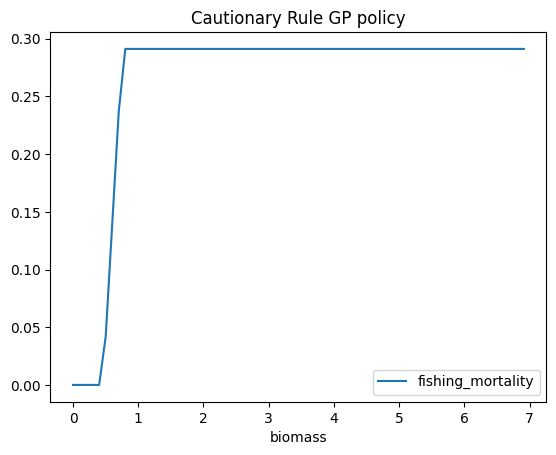

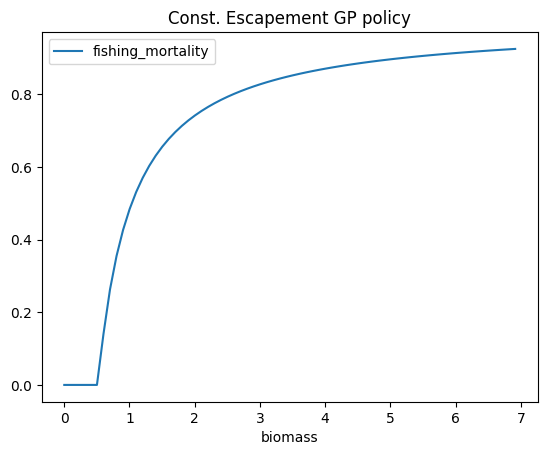

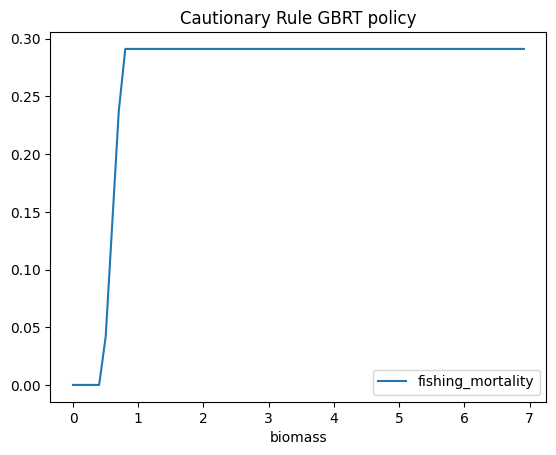

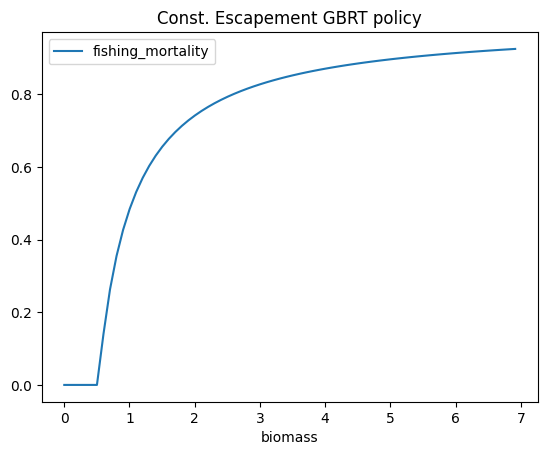

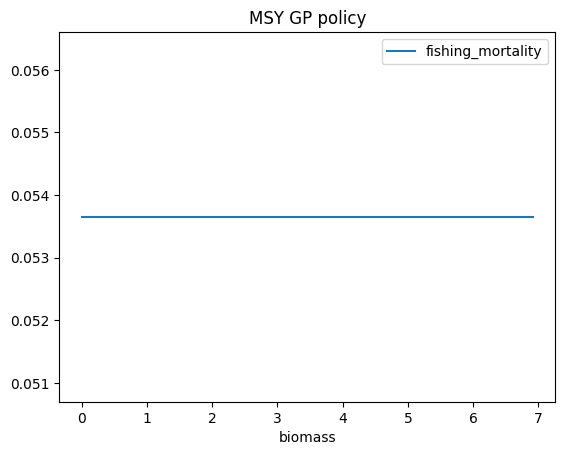

In [110]:
plt.show()

# Saving results

### MSY

In [16]:
path = "../saved_agents/"
fname = "msy_gp.pkl"
dump(msy_gp, path+fname)

api.upload_file(
    path_or_fileobj=path+fname,
    path_in_repo="sb3/rl4fisheries/"+fname,
    repo_id="boettiger-lab/rl4eco",
    repo_type="model",
)

path = "../saved_agents/"
fname = "msy_gbrt.pkl"
dump(msy_gbrt, path+fname)

api.upload_file(
    path_or_fileobj=path+fname,
    path_in_repo="sb3/rl4fisheries/"+fname,
    repo_id="boettiger-lab/rl4eco",
    repo_type="model",
)

msy_gp.pkl:   0%|          | 0.00/147M [00:00<?, ?B/s]

msy_gbrt.pkl:   0%|          | 0.00/38.6M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/boettiger-lab/rl4eco/commit/484b32797dd83973c461c06d54c0b92d9bf35c8d', commit_message='Upload sb3/rl4fisheries/msy_gbrt.pkl with huggingface_hub', commit_description='', oid='484b32797dd83973c461c06d54c0b92d9bf35c8d', pr_url=None, pr_revision=None, pr_num=None)

### Esc

In [17]:
path = "../saved_agents/"
fname = "esc_gp.pkl"
dump(esc_gp, path+fname)

api.upload_file(
    path_or_fileobj=path+fname,
    path_in_repo="sb3/rl4fisheries/"+fname,
    repo_id="boettiger-lab/rl4eco",
    repo_type="model",
)

path = "../saved_agents/"
fname = "esc_gbrt.pkl"
dump(esc_gbrt, path+fname)

api.upload_file(
    path_or_fileobj=path+fname,
    path_in_repo="sb3/rl4fisheries/"+fname,
    repo_id="boettiger-lab/rl4eco",
    repo_type="model",
)

esc_gp.pkl:   0%|          | 0.00/147M [00:00<?, ?B/s]

esc_gbrt.pkl:   0%|          | 0.00/39.5M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/boettiger-lab/rl4eco/commit/e4d077578d1d11f4ac1b82dc7d09c9fcc3b68749', commit_message='Upload sb3/rl4fisheries/esc_gbrt.pkl with huggingface_hub', commit_description='', oid='e4d077578d1d11f4ac1b82dc7d09c9fcc3b68749', pr_url=None, pr_revision=None, pr_num=None)

### CR

In [18]:
path = "../saved_agents/"
fname = "cr_gp.pkl"
dump(cr_gp, path+fname)

api.upload_file(
    path_or_fileobj=path+fname,
    path_in_repo="sb3/rl4fisheries/"+fname,
    repo_id="boettiger-lab/rl4eco",
    repo_type="model",
)

path = "../saved_agents/"
fname = "cr_gbrt.pkl"
dump(cr_gbrt, path+fname)

api.upload_file(
    path_or_fileobj=path+fname,
    path_in_repo="sb3/rl4fisheries/"+fname,
    repo_id="boettiger-lab/rl4eco",
    repo_type="model",
)

cr_gp.pkl:   0%|          | 0.00/148M [00:00<?, ?B/s]

cr_gbrt.pkl:   0%|          | 0.00/148M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/boettiger-lab/rl4eco/commit/f97125447bc0007bb7d5e8ae578e0e91a96e3cbe', commit_message='Upload sb3/rl4fisheries/cr_gbrt.pkl with huggingface_hub', commit_description='', oid='f97125447bc0007bb7d5e8ae578e0e91a96e3cbe', pr_url=None, pr_revision=None, pr_num=None)

# Cross evaluate

In [5]:
msy_gbrt_args = {'mortality': 0.05365088255575121}
esc_gbrt_args = {'escapement': 0.010338225232077163}
cr_gbrt_args = {
    'x1': 0.009159055923137423,
    'x2': 0.015139834077385755,
    'y2': 0.29119675741251316,
}

In [16]:
pol_env = AsmEnv(config=CONFIG)

msy_rews = eval_pol(
    policy=Msy(env=pol_env, **msy_gbrt_args), 
    env_cls=AsmEnv, config=CONFIG, 
    n_batches=5, batch_size=70
)

esc_rews = eval_pol(
    policy=ConstEsc(env=pol_env, **esc_gbrt_args), 
    env_cls=AsmEnv, config=CONFIG, 
    n_batches=5, batch_size=70
)

cr_rews = eval_pol(
    policy=CautionaryRule(env=pol_env, **cr_gbrt_args), 
    env_cls=AsmEnv, config=CONFIG, 
    n_batches=5, batch_size=70
)

2024-04-19 19:57:16,746	INFO worker.py:1752 -- Started a local Ray instance.
2024-04-19 19:57:23,514	INFO worker.py:1752 -- Started a local Ray instance.
2024-04-19 19:57:30,652	INFO worker.py:1752 -- Started a local Ray instance.
2024-04-19 19:57:37,784	INFO worker.py:1752 -- Started a local Ray instance.
2024-04-19 19:57:44,630	INFO worker.py:1752 -- Started a local Ray instance.
2024-04-19 19:57:51,285	INFO worker.py:1752 -- Started a local Ray instance.
2024-04-19 19:57:58,210	INFO worker.py:1752 -- Started a local Ray instance.
2024-04-19 19:58:05,222	INFO worker.py:1752 -- Started a local Ray instance.
2024-04-19 19:58:11,999	INFO worker.py:1752 -- Started a local Ray instance.
2024-04-19 19:58:18,799	INFO worker.py:1752 -- Started a local Ray instance.
2024-04-19 19:58:25,769	INFO worker.py:1752 -- Started a local Ray instance.
2024-04-19 19:58:32,700	INFO worker.py:1752 -- Started a local Ray instance.
2024-04-19 19:58:39,627	INFO worker.py:1752 -- Started a local Ray instance.

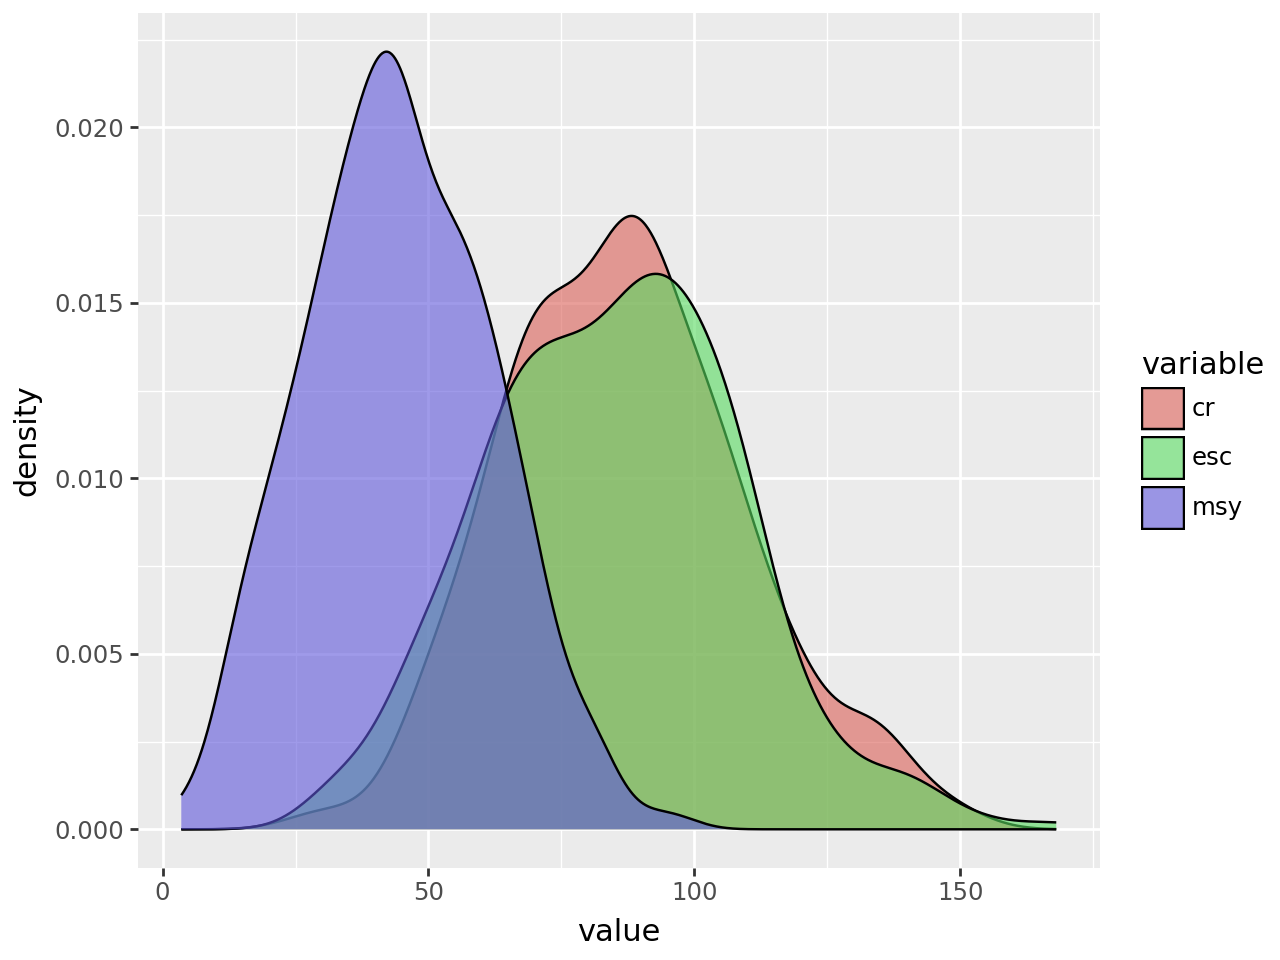

In [17]:
from plotnine import ggplot, aes, geom_point, geom_jitter, geom_density

df = pd.DataFrame({
    'msy': msy_rews,
    'esc': esc_rews,
    'cr': cr_rews,
}).melt()
df.head()
ggplot(df, aes(x='variable', y='value', color='variable')) + geom_point() + geom_jitter() 
ggplot(df, aes(x='value', fill='variable'))+ geom_density(alpha=0.6)

In [22]:
# df.to_csv("fixed_policies_rews.csv")
np.mean(df[df.variable=='esc'].value)

84.61410688701288

In [41]:
(
    msy_gp_args, # {'mortality': 0.055692588594477406}
    esc_gp_args, # {'escapement': 0.10036884302580139}
    cr_gp_args,
# ({'mortality': 0.05365088255575121},
 # {'escapement': 0.010338225232077163},
 # {'x1': 0.009159055923137423,
 #  'x2': 0.015139834077385755,
 #  'y2': 0.29119675741251316})
)

({'mortality': 0.05365088255575121},
 {'escapement': 0.010338225232077163},
 {'x1': 0.009159055923137423,
  'x2': 0.015139834077385755,
  'y2': 0.29119675741251316})

In [89]:
msy_gp_args = {'mortality': 0.05365088255575121}
esc_gp_args = {'escapement': 0.010338225232077163}
cr_gp_args = {
    'x1': 0.009159055923137423,
    'x2': 0.015139834077385755,
    'y2': 0.29119675741251316
}

## Evaluate RL too

In [19]:
pol_env = AsmEnv(config=CONFIG)

msy_rews = eval_pol(
    policy=Msy(env=pol_env, **msy_gbrt_args), 
    env_cls=AsmEnv, config=PPO_CONFIG, 
    n_batches=3, batch_size=120
)

esc_rews = eval_pol(
    policy=ConstEsc(env=pol_env, **esc_gbrt_args), 
    env_cls=AsmEnv, config=PPO_CONFIG, 
    n_batches=3, batch_size=120
)

cr_rews = eval_pol(
    policy=CautionaryRule(env=pol_env, **cr_gbrt_args), 
    env_cls=AsmEnv, config=PPO_CONFIG, 
    n_batches=3, batch_size=120
)

2024-04-19 20:01:42,264	INFO worker.py:1752 -- Started a local Ray instance.
2024-04-19 20:01:50,971	INFO worker.py:1752 -- Started a local Ray instance.
2024-04-19 20:01:58,657	INFO worker.py:1752 -- Started a local Ray instance.
2024-04-19 20:02:06,722	INFO worker.py:1752 -- Started a local Ray instance.
2024-04-19 20:02:14,103	INFO worker.py:1752 -- Started a local Ray instance.
2024-04-19 20:02:21,969	INFO worker.py:1752 -- Started a local Ray instance.
2024-04-19 20:02:29,441	INFO worker.py:1752 -- Started a local Ray instance.
2024-04-19 20:02:37,001	INFO worker.py:1752 -- Started a local Ray instance.
2024-04-19 20:02:45,499	INFO worker.py:1752 -- Started a local Ray instance.


In [20]:
from stable_baselines3 import PPO

PPO_CONFIG = { 
    "observation_fn_id": 'observe_2o',
    "n_observs": 2,
}

ppo = PPO.load("../saved_agents/PPO-AsmEnv-2o.zip", env=AsmEnv(config=PPO_CONFIG), device='cpu')

In [21]:
# ppo_rews = evaluate_policy(
#     ppo, env=Monitor(AsmEnv(
#         config=PPO_CONFIG
#     )), 
#     return_episode_rewards=True,
#     n_eval_episodes = 200,
# )[0]

ppo_rews = eval_pol(
    policy=ppo, 
    env_cls=AsmEnv, config=PPO_CONFIG, 
    n_batches=3, batch_size=120
)

2024-04-19 20:02:53,005	INFO worker.py:1752 -- Started a local Ray instance.
2024-04-19 20:03:07,046	INFO worker.py:1752 -- Started a local Ray instance.
2024-04-19 20:03:21,700	INFO worker.py:1752 -- Started a local Ray instance.


In [22]:
msy_df = pd.DataFrame(
    {
        'policy': ['msy'] * len(msy_rews),
        'rew': msy_rews,
    }
)

esc_df = pd.DataFrame(
    {
        'policy': ['esc'] * len(esc_rews),
        'rew': esc_rews,
    }
)

cr_df = pd.DataFrame(
    {
        'policy': ['cr'] * len(cr_rews),
        'rew': cr_rews,
    }
)

ppo_df = pd.DataFrame(
    {
        'policy': ['ppo'] * len(ppo_rews),
        'rew': ppo_rews,
    }
)

evaluation = pd.concat([msy_df, esc_df, cr_df, ppo_df])

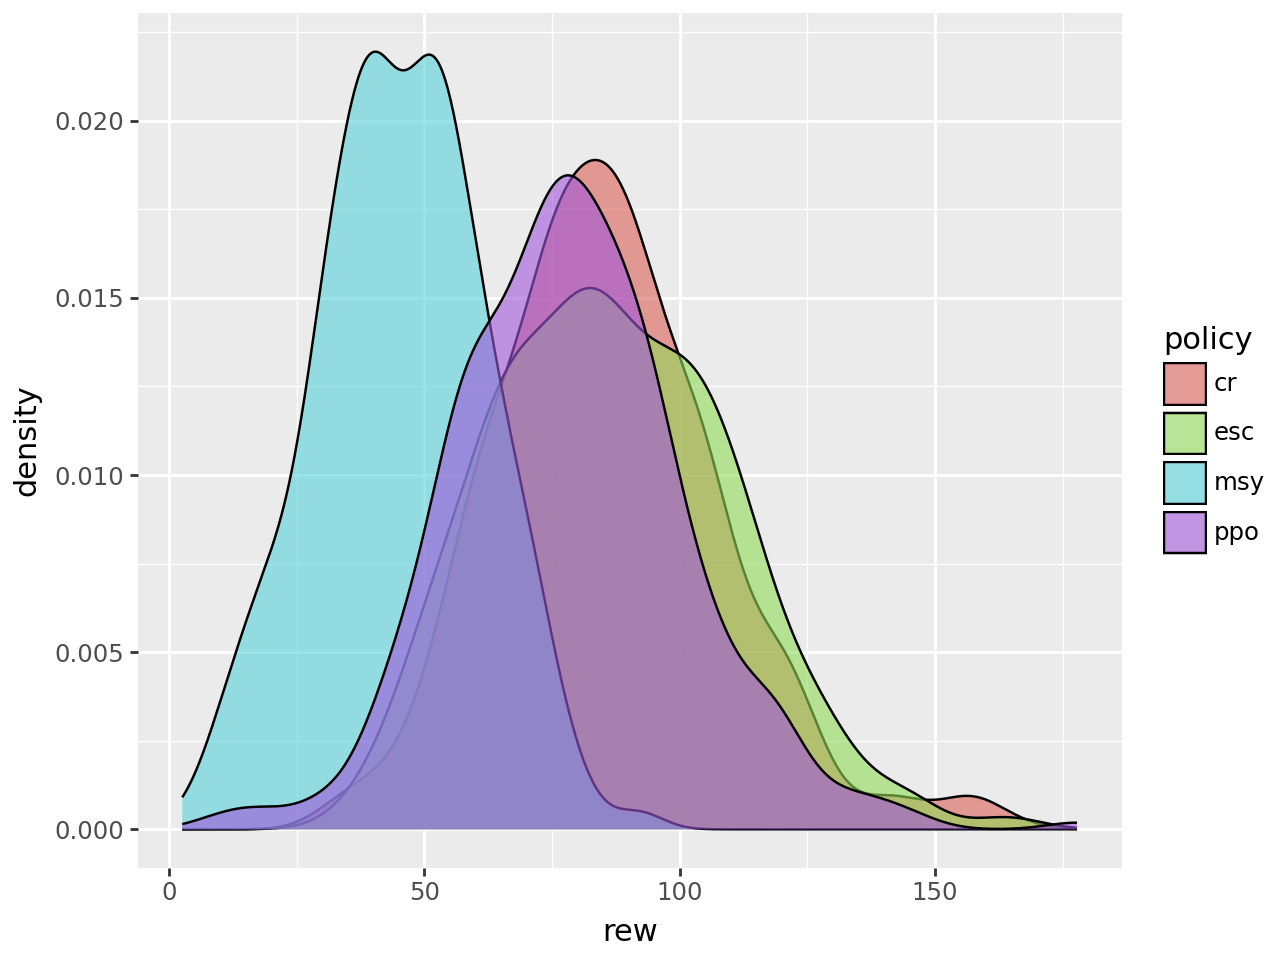

In [23]:
from plotnine import ggplot, aes, geom_density
ggplot(evaluation, aes(x='rew', fill='policy')) + geom_density(alpha=0.6)

## Plotting the RL policy

In [100]:
import itertools
env = AsmEnv()
BOUND = env.bound
MAXWT = env.parameters["max_wt"]
MINWT = env.parameters["min_wt"]

def policy_1obs(policy_obj, minx=-1, maxx=1, nx=200):
    obs_list = np.linspace(minx, maxx, nx)
    return {
            'obs': obs_list,
            'pop': (obs_list + 1)/2,
            'pol': [policy_obj.predict(np.array([obs]))[0][0] for obs in obs_list]
        }

def policy_2obs(policy_obj, minx=-1, miny=-1, maxx=1, maxy=1, nx=100, ny=100, obs1_name = 'obs1', obs2_name='obs2'):
    x_obs = np.linspace(minx, maxx, nx)
    y_obs = np.linspace(miny, maxy, ny)
    obs_generator = itertools.product(x_obs, y_obs)
    # obs_list = list(obs_generator)
    out_dict = {obs1_name: [], obs2_name: [], 'pol': []}
    for (obs1, obs2) in obs_generator:
        out_dict[obs1_name].append( BOUND * (obs1+1)/2 )
        out_dict[obs2_name].append( MINWT + (MAXWT - MINWT) * (obs2+1)/2 )
        action = policy_obj.predict(np.float32([obs1, obs2]))[0][0]
        mortality = (action+1)/2
        out_dict['pol'].append(mortality)
    
    return out_dict

In [56]:
AsmEnv().bound

50

In [57]:
# %pip install seaborn

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns
# plt.close()

maxx=-0.7
maxy=1
n_ticks = 10

ppo_pol = pd.DataFrame(policy_2obs(ppo, maxx=maxx, maxy=maxy, obs1_name='biomass', obs2_name='mean_wt'))
ppo_pol_pivot = ppo_pol.pivot(index='biomass', columns='mean_wt', values='pol')


In [102]:
plt.close()

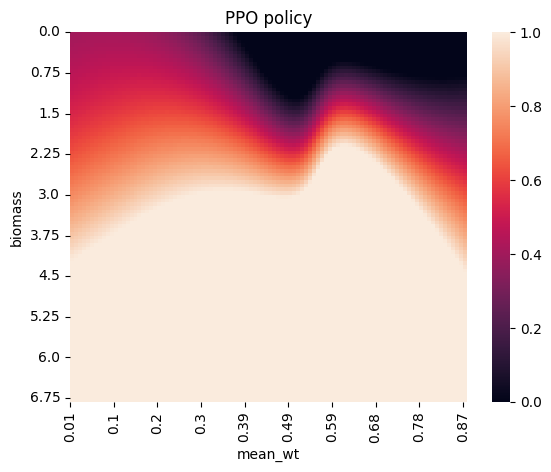

In [103]:
ax = sns.heatmap(ppo_pol_pivot)
ax.set_yticks(list(range(0, 101, 100//n_ticks + 1))) # locations as indices, not values
ax.set_yticklabels([eval(f"{ (i / n_ticks) * BOUND * (maxx+1)/ 2 :.2f}") for i in range(n_ticks)])
ax.set_xticks(list(range(0, 101, 100//n_ticks + 1))) # locations as indices, not values
ax.set_xticklabels([
    eval(f"{ MINWT + (i / n_ticks) * (MAXWT-MINWT) * (maxy+1)/ 2:.2f}") for i in range(n_ticks)
])
ax.set_title("PPO policy")
plt.show()

In [104]:
wt_indexes = [40, 50, 60, 45]

ppo_pol_1 = ppo_pol[ppo_pol.mean_wt == ppo_pol.mean_wt[wt_indexes[0]]]
ppo_pol_2 = ppo_pol[ppo_pol.mean_wt == ppo_pol.mean_wt[wt_indexes[1]]]
ppo_pol_3 = ppo_pol[ppo_pol.mean_wt == ppo_pol.mean_wt[wt_indexes[2]]]
ppo_pol_4 = ppo_pol[ppo_pol.mean_wt == ppo_pol.mean_wt[wt_indexes[3]]]



ppo_plot = pd.DataFrame(
    {
        'biomass': list(ppo_pol_1.biomass),
        f'action at m. wt = {ppo_pol.mean_wt[wt_indexes[0]]:.3f}': list(ppo_pol_1.pol),
        f'action at m. wt = {ppo_pol.mean_wt[wt_indexes[3]]:.3f}': list(ppo_pol_4.pol),
        f'action at m. wt = {ppo_pol.mean_wt[wt_indexes[1]]:.3f}': list(ppo_pol_2.pol),
        f'action at m. wt = {ppo_pol.mean_wt[wt_indexes[2]]:.3f}': list(ppo_pol_3.pol),
    }
)



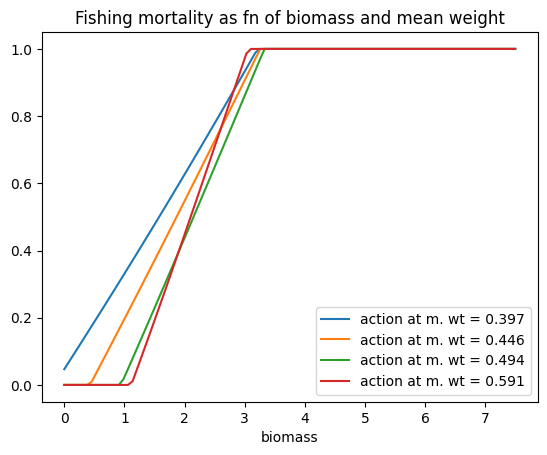

In [105]:
ppo_plot.plot(x='biomass', title="Fishing mortality as fn of biomass and mean weight")
plt.show()

In [111]:
cr_pol_df = cr_gbrt_df[cr_gbrt_df.biomass <= 7][['biomass', 'fishing_mortality']]
cr_pol_df['policy'] = 'cr'

esc_pol_df = esc_gbrt_df[esc_gbrt_df.biomass <= 7][['biomass', 'fishing_mortality']]
esc_pol_df['policy'] = 'esc'

ppo_pol_df_1 = ppo_pol_1
ppo_pol_df_1['policy'] = 'ppo_mwt_0.397'
ppo_pol_df_1['fishing_mortality'] = ppo_pol_df_1['pol']

ppo_pol_df_2 = ppo_pol_2
ppo_pol_df_2['policy'] = 'ppo_mwt_0.494'
ppo_pol_df_2['fishing_mortality'] = ppo_pol_df_2['pol']

ppo_pol_df_3 = ppo_pol_3
ppo_pol_df_3['policy'] = 'ppo_mwt_0.591'
ppo_pol_df_3['fishing_mortality'] = ppo_pol_df_3['pol']

ppo_pol_df_4 = ppo_pol_4
ppo_pol_df_4['policy'] = 'ppo_mwt_0.446'
ppo_pol_df_4['fishing_mortality'] = ppo_pol_df_4['pol']

df = pd.concat([
    cr_pol_df,
    esc_pol_df,
    ppo_pol_df_1[esc_pol_df.columns],
    ppo_pol_df_4[esc_pol_df.columns],
    ppo_pol_df_2[esc_pol_df.columns],
    ppo_pol_df_3[esc_pol_df.columns],
])


/tmp/ipykernel_1226226/693145116.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_1226226/693145116.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_1226226/693145116.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_122

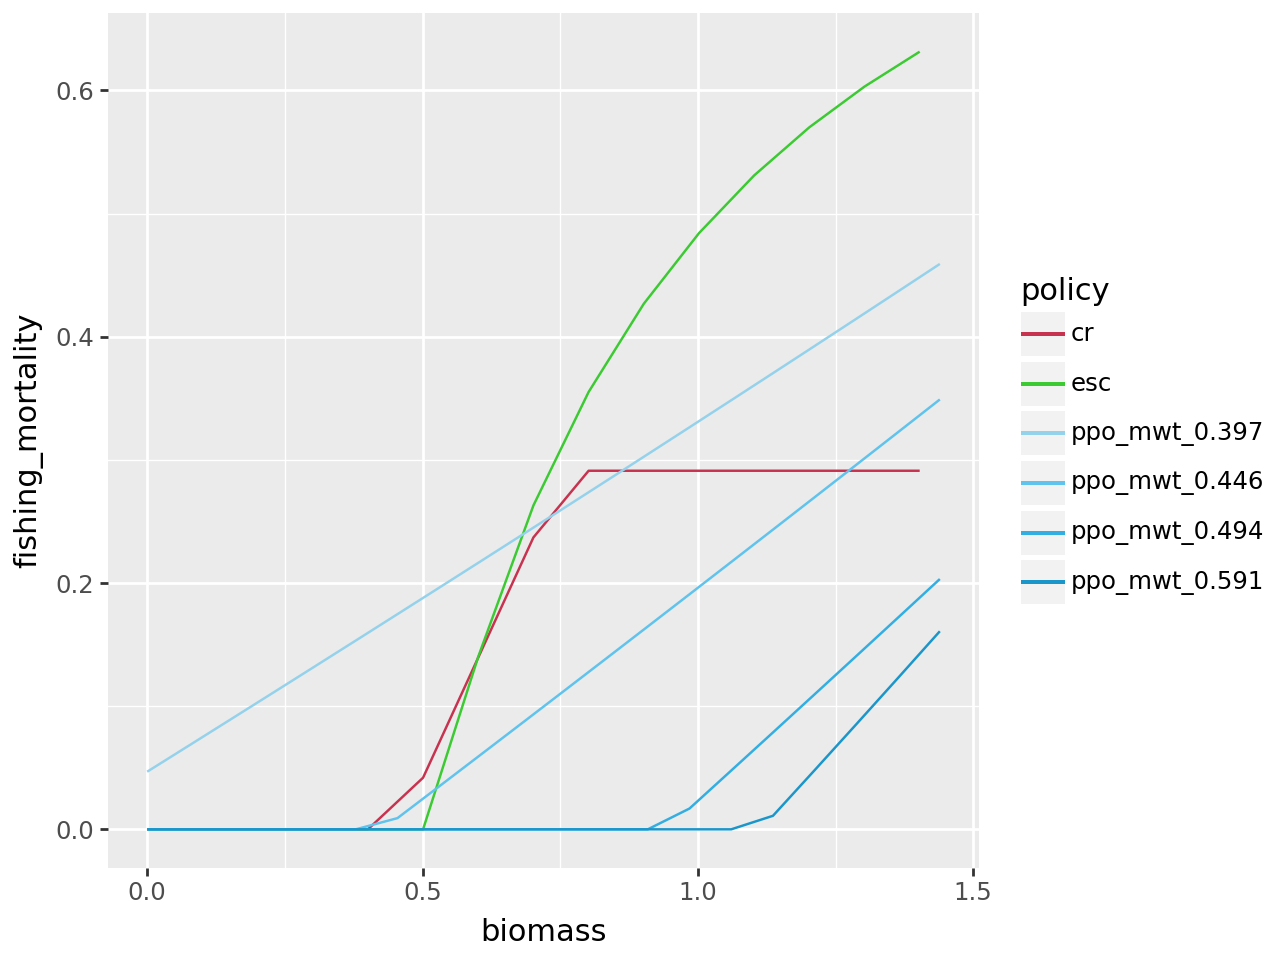

In [112]:
from plotnine import geom_line, scale_color_manual

colors = {
    'ppo_mwt_0.397': '#94D2EC',
    'ppo_mwt_0.446': '#5FC3ED',
    'ppo_mwt_0.494': '#32AEE2',
    'ppo_mwt_0.591': '#1B96CA',
    'esc': '#3CCA33',
    'cr': '#C7324F',
}

( 
    ggplot(df[df.biomass < 1.5], aes(x='biomass', y='fishing_mortality',  color='policy')) 
    + geom_line() 
    + scale_color_manual(values=colors)
)

## Variable density plots

In [67]:
@ray.remote
def variable_values_over_ep(env, agent, n_obs=1):
    obs1_list = []
    obs2_list = []
    act_list = []
    rew_list = []
    obs, info = env.reset()
    for t in range(env.Tmax):
        action, info = agent.predict(obs)
        new_obs, rew, term, trunc, info = env.step(action)
        obs1_list.append(obs[0])
        if n_obs == 2:
            obs2_list.append(obs[1])
        else:
            obs2_list.append(0)
        act_list.append(action[0])
        rew_list.append(rew)
        obs = new_obs
        if term or trunc:
            break
    return obs1_list, obs2_list, act_list, rew_list


def get_var_distributions(agent, agent_name, env, n_obs=1):
    var_tuples_of_lists = ray.get(
        [
            variable_values_over_ep.remote(env, agent) for _ in range(10)
        ]
    )
    if ray.is_initialized():
        ray.shutdown()
    
    obs1 = np.array([tup[0] for tup in var_tuples_of_lists]).flatten()
    obs2 = np.array([tup[1] for tup in var_tuples_of_lists]).flatten()
    act = np.array([tup[2] for tup in var_tuples_of_lists]).flatten()
    rew = np.array([tup[3] for tup in var_tuples_of_lists]).flatten()

    biomass = BOUND * (obs1 + 1)/2
    if n_obs==2:
        mean_wt = MINWT + (MAXWT - MINWT) * (obs2 + 1)/2
    else:
        mean_wt = obs2
    mortality = (act + 1)/2

    return pd.DataFrame({
        'agent': agent_name,
        'biomass': biomass,
        'mean_wt': mean_wt,
        'mortality': mortality,
        'rew': rew,
    })

In [76]:
ppo_distr_df = get_var_distributions(
    agent=ppo, 
    agent_name='ppo', 
    env = AsmEnv(config=PPO_CONFIG), 
    n_obs=2,
)

cr_distr_df = get_var_distributions(
    agent=CautionaryRule(env=pol_env, **cr_gbrt_args), 
    agent_name='cr', 
    env = AsmEnv(config=PPO_CONFIG), 
    n_obs=2,
)

esc_distr_df = get_var_distributions(
    agent=ConstEsc(env=pol_env, **esc_gbrt_args), 
    agent_name='esc', 
    env = AsmEnv(config=PPO_CONFIG), 
    n_obs=2,
)

2024-04-19 20:32:29,101	INFO worker.py:1752 -- Started a local Ray instance.
2024-04-19 20:32:38,134	INFO worker.py:1752 -- Started a local Ray instance.
2024-04-19 20:32:45,098	INFO worker.py:1752 -- Started a local Ray instance.


In [77]:
vars_df = pd.concat([ppo_distr_df, cr_distr_df, esc_distr_df])

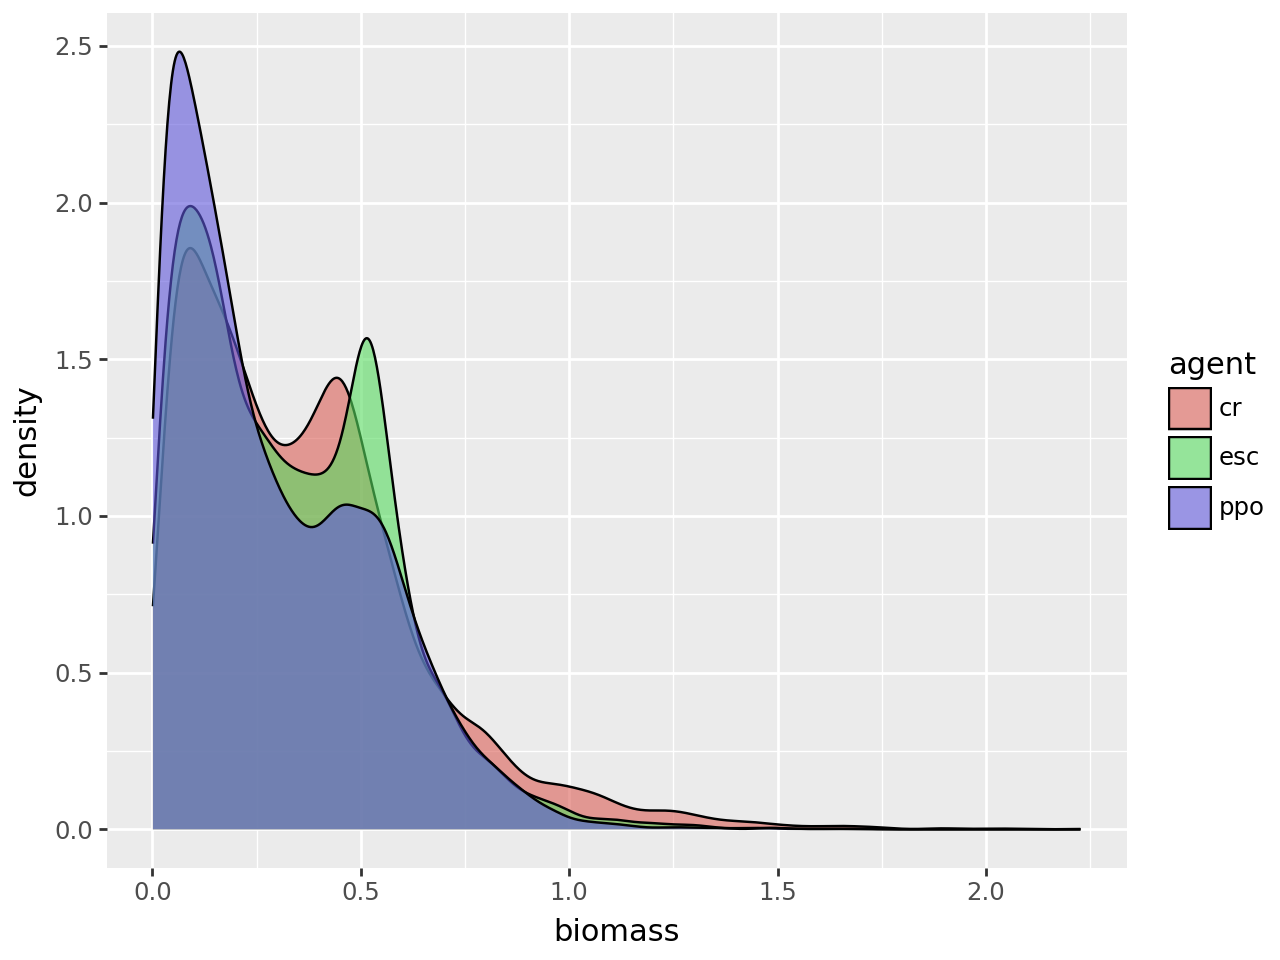

In [78]:
ggplot(vars_df, aes(x='biomass', fill='agent')) + geom_density(alpha=0.6)

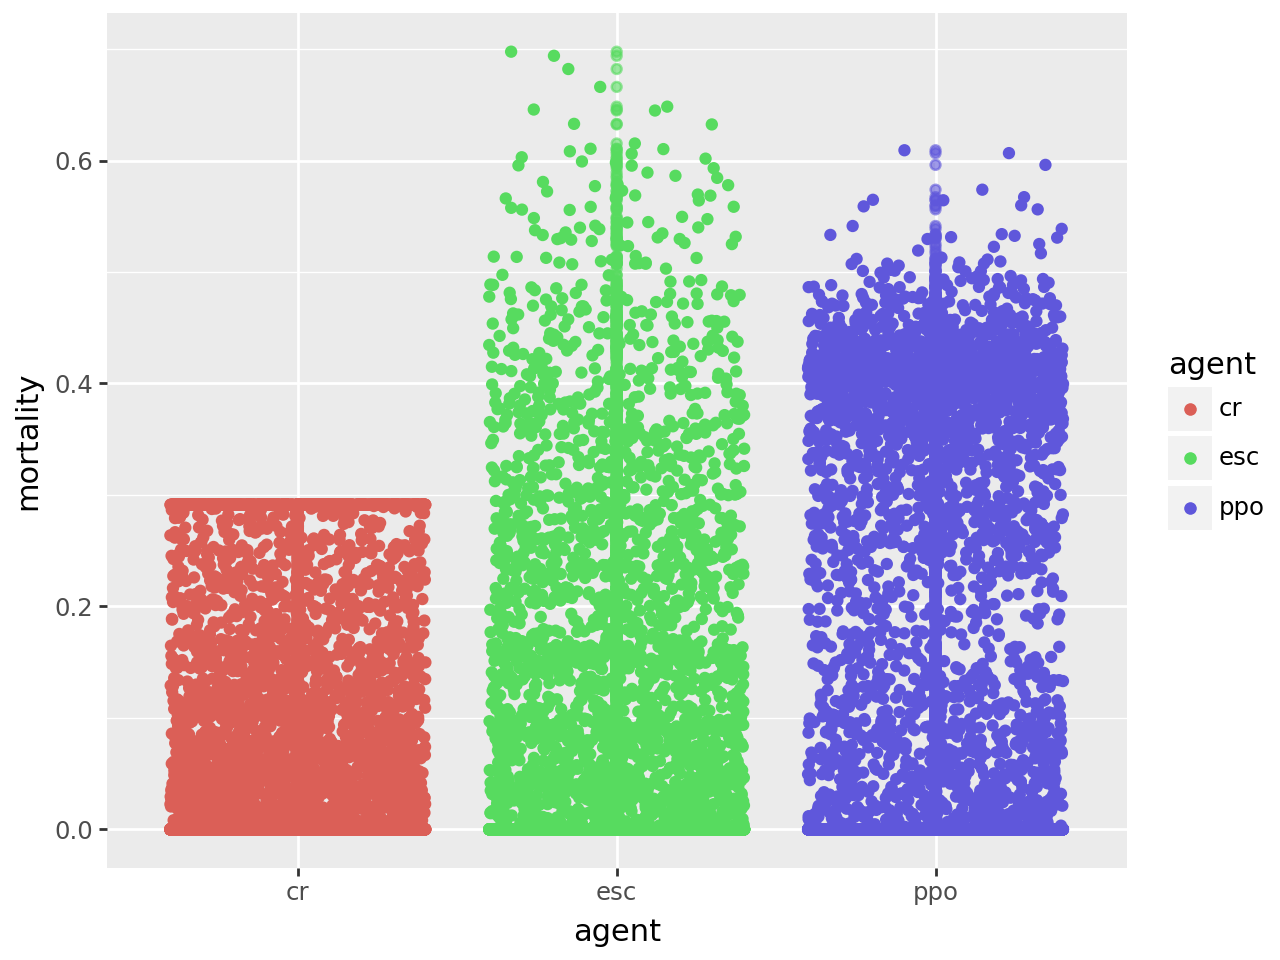

In [79]:
# from plotnine import scale_x_log10, xlim, scale_y_log10
# ggplot(vars_df, aes(x='mortality', fill='agent')) + geom_density(alpha=0.6) + xlim(0,0.5) + scale_y_log10()

ggplot(vars_df, aes(y='mortality', x='agent',color='agent')) + geom_point(alpha=0.6) + geom_jitter()

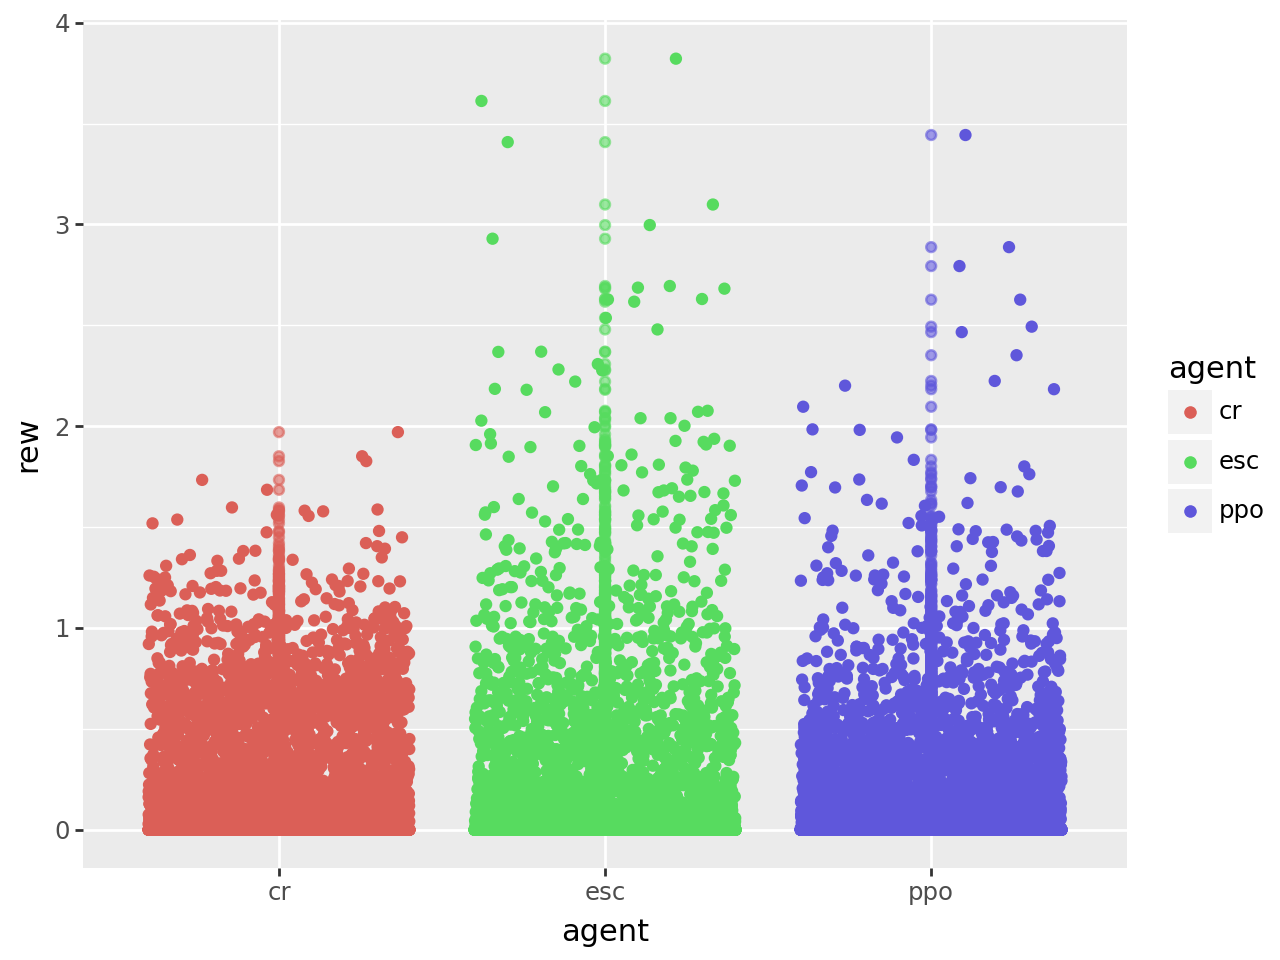

In [80]:
# ggplot(vars_df, aes(x='rew', fill='agent')) + geom_density(alpha=0.6) + scale_x_log10()
ggplot(vars_df, aes(y='rew', x='agent',color='agent')) + geom_point(alpha=0.6) + geom_jitter()

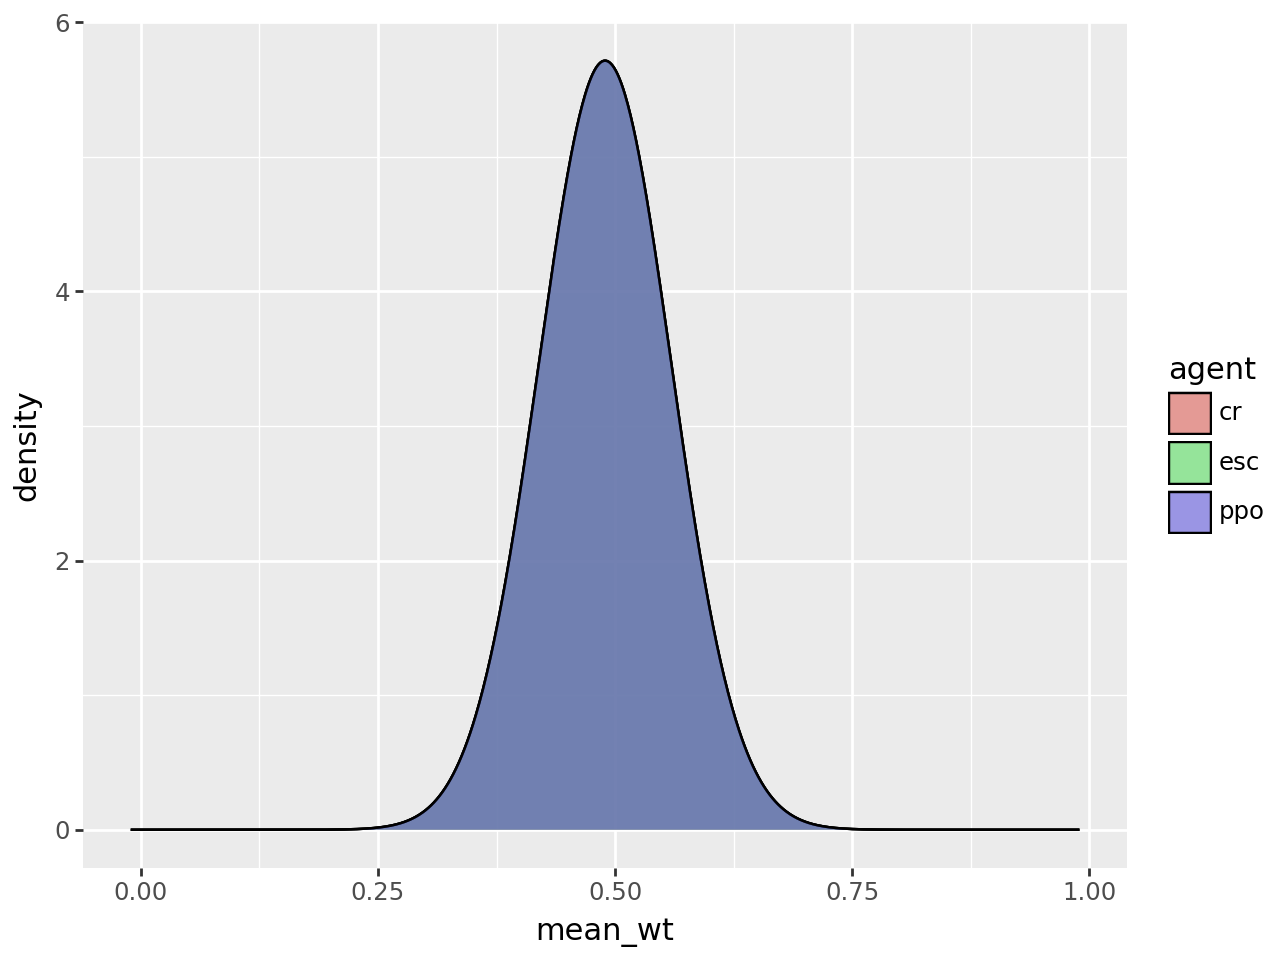

In [82]:
ggplot(vars_df, aes(x='mean_wt', fill='agent')) + geom_density(alpha=0.6)
# ggplot(vars_df, aes(y='mean_wt', x='agent',color='agent')) + geom_point(alpha=0.6) + geom_jitter()

In [119]:
MINWT, MAXWT

(0.00867406, 0.9701466)

In [ ]:
from plotnine import xlim

ggplot(vars_df, aes(x='mortality', fill='agent')) + geom_density(alpha=0.6) + xlim(0,0.1)

In [ ]:
ggplot(vars_df, aes(y='mortality', x='agent', color='agent')) + geom_point() + geom_jitter() + xlim(0,0.1)

# Observing mean weight instead of biomass
---
## Setup


In [1]:
import numpy as np
import pandas as pd
import ray

from skopt import gp_minimize, gbrt_minimize 
from skopt import dump
from skopt.plots import plot_objective, plot_convergence
from skopt.space import Real
from skopt.utils import use_named_args

from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

from rl4fisheries import AsmEnv, Msy, ConstEsc, CautionaryRule
from rl4fisheries.envs.asm_fns import get_r_devs, observe_total

In [2]:
CONFIG = {
    'observation_fn_id': 'observe_2o', 
    'n_observs': 2, 
}

In [3]:
@ray.remote
def generate_rew(policy, env_cls, config):
    ep_rew = 0
    env = env_cls(config=config)
    obs, info = env.reset()
    for t in range(env.Tmax):
        act, info = policy.predict(obs)
        obs, rew, term, trunc, info = env.step(act)
        ep_rew += rew
    return ep_rew


def rew_batch(policy, env_cls, config, batch_size):
    tmax = env_cls().Tmax
    parallel = [generate_rew.remote(policy, env_cls, config) for _ in range(batch_size)]
    rews = ray.get(parallel)
    if ray.is_initialized():
        ray.shutdown()
    return rews

def eval_pol(policy, env_cls, config, n_batches=4, batch_size=40, pb=False):
    batch_iter = range(n_batches)
    if pb:
        from tqdm import tqdm
        batch_iter = tqdm(iter)
    #
    rews = []
    for i in batch_iter:
        rews.append(
            rew_batch(policy=policy, env_cls=env_cls, config=config, batch_size=batch_size)
        )
    return np.array(rews).flatten()

In [4]:
log_esc_space = [Real(-6, 2, name='log_escapement')]
cr_space  = [
    Real(-5, 0, name='log_radius'),
    Real(0., np.pi/4.00001, name='theta'),
    Real(0, 1, name='y2'),
]


@use_named_args(log_esc_space)
def esc_mw_obj(**x):
    eval_env = AsmEnv(config=CONFIG)
    escapement = 10 ** x['log_escapement']
    agent = ConstEsc(
        env=eval_env, 
        escapement=escapement, 
        observed_var='mean_wt',
    )
    rews = eval_pol(
        policy=agent, 
        env_cls=AsmEnv, config=CONFIG, 
        n_batches=1, batch_size=200
    )
    return -np.mean(rews)

@use_named_args(cr_space)
def cr_mwt_obj(**x):
    theta = x["theta"]
    radius = 10 ** x["log_radius"]
    x1 = np.sin(theta) * radius
    x2 = np.cos(theta) * radius
    #
    eval_env = AsmEnv(config=CONFIG)
    eval_env.reset()
    agent = CautionaryRule(
        env=eval_env, 
        x1=x1, x2=x2, y2=x["y2"],
        observed_var='mean_wt',
    )
    rews = eval_pol(
        policy=agent, 
        env_cls=AsmEnv, 
        config=CONFIG, 
        n_batches=1, batch_size=200
    )
    return -np.mean(rews)  



In [5]:
%%time
esc_gp = gp_minimize(esc_mw_obj, log_esc_space, n_calls = 50, verbose=True, n_jobs=-1)
esc_gp.fun, esc_gp.x

Iteration No: 1 started. Evaluating function at random point.


2024-04-25 17:43:04,108	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 7.2468
Function value obtained: -1.9048
Current minimum: -1.9048
Iteration No: 2 started. Evaluating function at random point.


2024-04-25 17:43:11,288	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 7.2018
Function value obtained: -1.9737
Current minimum: -1.9737
Iteration No: 3 started. Evaluating function at random point.


2024-04-25 17:43:18,514	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 6.8578
Function value obtained: -1.9354
Current minimum: -1.9737
Iteration No: 4 started. Evaluating function at random point.


2024-04-25 17:43:25,345	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 7.0262
Function value obtained: -2.0507
Current minimum: -2.0507
Iteration No: 5 started. Evaluating function at random point.


2024-04-25 17:43:32,404	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 7.0535
Function value obtained: -0.0000
Current minimum: -2.0507
Iteration No: 6 started. Evaluating function at random point.


2024-04-25 17:43:39,532	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 7.0462
Function value obtained: -0.0000
Current minimum: -2.0507
Iteration No: 7 started. Evaluating function at random point.


2024-04-25 17:43:46,549	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 7.2075
Function value obtained: -2.0646
Current minimum: -2.0646
Iteration No: 8 started. Evaluating function at random point.


2024-04-25 17:43:53,820	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 7.3153
Function value obtained: -1.9315
Current minimum: -2.0646
Iteration No: 9 started. Evaluating function at random point.


2024-04-25 17:44:01,054	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 7.0475
Function value obtained: -2.1287
Current minimum: -2.1287
Iteration No: 10 started. Evaluating function at random point.


2024-04-25 17:44:08,119	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 10.8057
Function value obtained: -1.8554
Current minimum: -2.1287
Iteration No: 11 started. Searching for the next optimal point.


2024-04-25 17:44:18,939	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 8.3912
Function value obtained: -1.9575
Current minimum: -2.1287
Iteration No: 12 started. Searching for the next optimal point.


2024-04-25 17:44:27,320	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 8.2712
Function value obtained: -1.9597
Current minimum: -2.1287
Iteration No: 13 started. Searching for the next optimal point.


2024-04-25 17:44:35,645	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 8.8549
Function value obtained: -2.0411
Current minimum: -2.1287
Iteration No: 14 started. Searching for the next optimal point.


/opt/venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [-6.0] before, using random point [0.3715626298528427]
  warnings.warn(
2024-04-25 17:44:44,423	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 8.4937
Function value obtained: -0.0000
Current minimum: -2.1287
Iteration No: 15 started. Searching for the next optimal point.


2024-04-25 17:44:52,982	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 8.4121
Function value obtained: -1.9700
Current minimum: -2.1287
Iteration No: 16 started. Searching for the next optimal point.


/opt/venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [-6.0] before, using random point [-5.419977199986665]
  warnings.warn(
2024-04-25 17:45:01,388	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 8.4600
Function value obtained: -1.9894
Current minimum: -2.1287
Iteration No: 17 started. Searching for the next optimal point.


2024-04-25 17:45:09,877	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 8.4054
Function value obtained: -2.0045
Current minimum: -2.1287
Iteration No: 18 started. Searching for the next optimal point.


/opt/venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [-6.0] before, using random point [-2.703683694288526]
  warnings.warn(
2024-04-25 17:45:18,267	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 8.1587
Function value obtained: -1.8827
Current minimum: -2.1287
Iteration No: 19 started. Searching for the next optimal point.


2024-04-25 17:45:26,412	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 7.4855
Function value obtained: -1.9271
Current minimum: -2.1287
Iteration No: 20 started. Searching for the next optimal point.


2024-04-25 17:45:33,929	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 7.2841
Function value obtained: -2.0115
Current minimum: -2.1287
Iteration No: 21 started. Searching for the next optimal point.


2024-04-25 17:45:41,196	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 7.3577
Function value obtained: -1.9363
Current minimum: -2.1287
Iteration No: 22 started. Searching for the next optimal point.


2024-04-25 17:45:48,556	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 7.7215
Function value obtained: -2.0020
Current minimum: -2.1287
Iteration No: 23 started. Searching for the next optimal point.


2024-04-25 17:45:56,290	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 7.5647
Function value obtained: -1.9813
Current minimum: -2.1287
Iteration No: 24 started. Searching for the next optimal point.


2024-04-25 17:46:03,885	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 7.6284
Function value obtained: -1.8912
Current minimum: -2.1287
Iteration No: 25 started. Searching for the next optimal point.


/opt/venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [-6.0] before, using random point [-1.0255907058676303]
  warnings.warn(
2024-04-25 17:46:11,493	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 7.6490
Function value obtained: -2.1065
Current minimum: -2.1287
Iteration No: 26 started. Searching for the next optimal point.


2024-04-25 17:46:19,174	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 7.5100
Function value obtained: -2.0861
Current minimum: -2.1287
Iteration No: 27 started. Searching for the next optimal point.


2024-04-25 17:46:26,654	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 7.2805
Function value obtained: -2.0434
Current minimum: -2.1287
Iteration No: 28 started. Searching for the next optimal point.


2024-04-25 17:46:33,959	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 7.6268
Function value obtained: -1.9285
Current minimum: -2.1287
Iteration No: 29 started. Searching for the next optimal point.


/opt/venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [-6.0] before, using random point [1.3826217743275695]
  warnings.warn(
2024-04-25 17:46:41,616	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 7.6558
Function value obtained: -0.0000
Current minimum: -2.1287
Iteration No: 30 started. Searching for the next optimal point.


2024-04-25 17:46:49,242	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 7.7707
Function value obtained: -2.0044
Current minimum: -2.1287
Iteration No: 31 started. Searching for the next optimal point.


/opt/venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [-6.0] before, using random point [1.8102285992201157]
  warnings.warn(
2024-04-25 17:46:57,024	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 7.6583
Function value obtained: -0.0000
Current minimum: -2.1287
Iteration No: 32 started. Searching for the next optimal point.


/opt/venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [-6.0] before, using random point [1.3859259110617854]
  warnings.warn(
2024-04-25 17:47:05,710	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 8.9140
Function value obtained: -0.0000
Current minimum: -2.1287
Iteration No: 33 started. Searching for the next optimal point.


2024-04-25 17:47:13,607	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 7.4819
Function value obtained: -1.9521
Current minimum: -2.1287
Iteration No: 34 started. Searching for the next optimal point.


/opt/venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [-6.0] before, using random point [0.10995143036891619]
  warnings.warn(
2024-04-25 17:47:21,086	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 7.7571
Function value obtained: -0.0000
Current minimum: -2.1287
Iteration No: 35 started. Searching for the next optimal point.


2024-04-25 17:47:28,882	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 7.4464
Function value obtained: -1.9466
Current minimum: -2.1287
Iteration No: 36 started. Searching for the next optimal point.


2024-04-25 17:47:36,303	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 7.5964
Function value obtained: -1.9455
Current minimum: -2.1287
Iteration No: 37 started. Searching for the next optimal point.


2024-04-25 17:47:43,922	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 7.5785
Function value obtained: -2.1195
Current minimum: -2.1287
Iteration No: 38 started. Searching for the next optimal point.


2024-04-25 17:47:51,490	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 7.6549
Function value obtained: -1.9578
Current minimum: -2.1287
Iteration No: 39 started. Searching for the next optimal point.


2024-04-25 17:47:59,156	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 7.6839
Function value obtained: -2.0423
Current minimum: -2.1287
Iteration No: 40 started. Searching for the next optimal point.


2024-04-25 17:48:06,842	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 8.5758
Function value obtained: -1.9169
Current minimum: -2.1287
Iteration No: 41 started. Searching for the next optimal point.


/opt/venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [-6.0] before, using random point [-0.12854283508189202]
  warnings.warn(
2024-04-25 17:48:15,422	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 7.7738
Function value obtained: -0.3884
Current minimum: -2.1287
Iteration No: 42 started. Searching for the next optimal point.


/opt/venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [-6.0] before, using random point [-1.7795068095198445]
  warnings.warn(
2024-04-25 17:48:23,228	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 7.6866
Function value obtained: -1.9185
Current minimum: -2.1287
Iteration No: 43 started. Searching for the next optimal point.


/opt/venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [-6.0] before, using random point [-4.462853949509887]
  warnings.warn(
2024-04-25 17:48:30,947	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 7.8422
Function value obtained: -1.8635
Current minimum: -2.1287
Iteration No: 44 started. Searching for the next optimal point.


/opt/venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [-6.0] before, using random point [1.862197976179674]
  warnings.warn(
2024-04-25 17:48:38,769	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 8.0573
Function value obtained: -0.0000
Current minimum: -2.1287
Iteration No: 45 started. Searching for the next optimal point.


/opt/venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [-6.0] before, using random point [-2.4203438877690298]
  warnings.warn(
2024-04-25 17:48:46,812	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 7.8161
Function value obtained: -1.9774
Current minimum: -2.1287
Iteration No: 46 started. Searching for the next optimal point.


/opt/venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [-6.0] before, using random point [-3.4506555127302057]
  warnings.warn(
2024-04-25 17:48:54,636	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 7.9360
Function value obtained: -1.8775
Current minimum: -2.1287
Iteration No: 47 started. Searching for the next optimal point.


/opt/venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [-6.0] before, using random point [-2.4324444495959483]
  warnings.warn(
2024-04-25 17:49:02,558	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 7.8956
Function value obtained: -1.8945
Current minimum: -2.1287
Iteration No: 48 started. Searching for the next optimal point.


/opt/venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [-6.0] before, using random point [-3.6627032192701106]
  warnings.warn(
2024-04-25 17:49:10,473	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 7.7399
Function value obtained: -1.9696
Current minimum: -2.1287
Iteration No: 49 started. Searching for the next optimal point.


/opt/venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [-6.0] before, using random point [-4.859554148703219]
  warnings.warn(
2024-04-25 17:49:18,222	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 7.9707
Function value obtained: -1.9285
Current minimum: -2.1287
Iteration No: 50 started. Searching for the next optimal point.


/opt/venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [-6.0] before, using random point [-5.7446808564087695]
  warnings.warn(
2024-04-25 17:49:26,192	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 8.0019
Function value obtained: -1.9361
Current minimum: -2.1287
CPU times: user 6min 43s, sys: 9min 27s, total: 16min 10s
Wall time: 6min 29s


(-2.1286563027031495, [-1.1965266045176186])

In [6]:
%%time
cr_gp = gp_minimize(cr_mwt_obj, cr_space, n_calls = 50, verbose=True, n_jobs=-1)
cr_gp.fun, cr_gp.x

Iteration No: 1 started. Evaluating function at random point.


2024-04-25 17:49:34,239	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 7.5362
Function value obtained: -3.0056
Current minimum: -3.0056
Iteration No: 2 started. Evaluating function at random point.


2024-04-25 17:49:41,792	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 7.3328
Function value obtained: -2.4511
Current minimum: -3.0056
Iteration No: 3 started. Evaluating function at random point.


2024-04-25 17:49:49,163	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 7.5459
Function value obtained: -2.0481
Current minimum: -3.0056
Iteration No: 4 started. Evaluating function at random point.


2024-04-25 17:49:56,692	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 7.5742
Function value obtained: -4.0016
Current minimum: -4.0016
Iteration No: 5 started. Evaluating function at random point.


2024-04-25 17:50:04,279	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 7.5454
Function value obtained: -2.5316
Current minimum: -4.0016
Iteration No: 6 started. Evaluating function at random point.


2024-04-25 17:50:11,814	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 7.7054
Function value obtained: -16.9847
Current minimum: -16.9847
Iteration No: 7 started. Evaluating function at random point.


2024-04-25 17:50:19,523	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 7.7268
Function value obtained: -13.3485
Current minimum: -16.9847
Iteration No: 8 started. Evaluating function at random point.


2024-04-25 17:50:27,261	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 8.3116
Function value obtained: -6.8201
Current minimum: -16.9847
Iteration No: 9 started. Evaluating function at random point.


2024-04-25 17:50:35,612	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 7.5522
Function value obtained: -43.3207
Current minimum: -43.3207
Iteration No: 10 started. Evaluating function at random point.


2024-04-25 17:50:43,105	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 7.6797
Function value obtained: -2.1571
Current minimum: -43.3207
Iteration No: 11 started. Searching for the next optimal point.


2024-04-25 17:50:50,711	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 7.8512
Function value obtained: -0.0000
Current minimum: -43.3207
Iteration No: 12 started. Searching for the next optimal point.


2024-04-25 17:50:58,633	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 7.7731
Function value obtained: -41.5928
Current minimum: -43.3207
Iteration No: 13 started. Searching for the next optimal point.


2024-04-25 17:51:06,425	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 8.0390
Function value obtained: -0.0000
Current minimum: -43.3207
Iteration No: 14 started. Searching for the next optimal point.


2024-04-25 17:51:14,553	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 8.6942
Function value obtained: -39.7440
Current minimum: -43.3207
Iteration No: 15 started. Searching for the next optimal point.


2024-04-25 17:51:23,185	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 7.9191
Function value obtained: -43.5548
Current minimum: -43.5548
Iteration No: 16 started. Searching for the next optimal point.


2024-04-25 17:51:32,107	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 9.0632
Function value obtained: -44.1675
Current minimum: -44.1675
Iteration No: 17 started. Searching for the next optimal point.


2024-04-25 17:51:40,181	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 8.2439
Function value obtained: -42.1269
Current minimum: -44.1675
Iteration No: 18 started. Searching for the next optimal point.


2024-04-25 17:51:48,410	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 8.7441
Function value obtained: -44.3219
Current minimum: -44.3219
Iteration No: 19 started. Searching for the next optimal point.


2024-04-25 17:51:57,211	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 8.1056
Function value obtained: -46.6821
Current minimum: -46.6821
Iteration No: 20 started. Searching for the next optimal point.


2024-04-25 17:52:05,280	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 8.8339
Function value obtained: -47.3783
Current minimum: -47.3783
Iteration No: 21 started. Searching for the next optimal point.


2024-04-25 17:52:14,145	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 7.9693
Function value obtained: -47.2997
Current minimum: -47.3783
Iteration No: 22 started. Searching for the next optimal point.


2024-04-25 17:52:22,093	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 8.0583
Function value obtained: -45.8191
Current minimum: -47.3783
Iteration No: 23 started. Searching for the next optimal point.


2024-04-25 17:52:30,181	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 8.0238
Function value obtained: -1.9344
Current minimum: -47.3783
Iteration No: 24 started. Searching for the next optimal point.


2024-04-25 17:52:38,113	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 7.9621
Function value obtained: -46.0481
Current minimum: -47.3783
Iteration No: 25 started. Searching for the next optimal point.


2024-04-25 17:52:46,163	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 8.8595
Function value obtained: -2.0613
Current minimum: -47.3783
Iteration No: 26 started. Searching for the next optimal point.


2024-04-25 17:52:54,922	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 8.7663
Function value obtained: -48.8415
Current minimum: -48.8415
Iteration No: 27 started. Searching for the next optimal point.


2024-04-25 17:53:03,775	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 8.2160
Function value obtained: -2.5755
Current minimum: -48.8415
Iteration No: 28 started. Searching for the next optimal point.


2024-04-25 17:53:12,023	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 8.1004
Function value obtained: -2.9925
Current minimum: -48.8415
Iteration No: 29 started. Searching for the next optimal point.


2024-04-25 17:53:20,126	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 8.8805
Function value obtained: -43.0760
Current minimum: -48.8415
Iteration No: 30 started. Searching for the next optimal point.


2024-04-25 17:53:29,008	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 8.1147
Function value obtained: -1.5035
Current minimum: -48.8415
Iteration No: 31 started. Searching for the next optimal point.


2024-04-25 17:53:37,125	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 8.5263
Function value obtained: -33.0037
Current minimum: -48.8415
Iteration No: 32 started. Searching for the next optimal point.


2024-04-25 17:53:45,647	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 8.7627
Function value obtained: -2.8038
Current minimum: -48.8415
Iteration No: 33 started. Searching for the next optimal point.


2024-04-25 17:53:54,307	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 8.6853
Function value obtained: -39.6488
Current minimum: -48.8415
Iteration No: 34 started. Searching for the next optimal point.


2024-04-25 17:54:03,120	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 8.2671
Function value obtained: -2.1287
Current minimum: -48.8415
Iteration No: 35 started. Searching for the next optimal point.


2024-04-25 17:54:11,387	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 8.7627
Function value obtained: -37.9392
Current minimum: -48.8415
Iteration No: 36 started. Searching for the next optimal point.


2024-04-25 17:54:20,156	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 9.0250
Function value obtained: -48.8930
Current minimum: -48.8930
Iteration No: 37 started. Searching for the next optimal point.


2024-04-25 17:54:29,047	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 8.6697
Function value obtained: -47.6254
Current minimum: -48.8930
Iteration No: 38 started. Searching for the next optimal point.


2024-04-25 17:54:37,875	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 8.9464
Function value obtained: -46.8607
Current minimum: -48.8930
Iteration No: 39 started. Searching for the next optimal point.


2024-04-25 17:54:46,778	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 8.8875
Function value obtained: -54.4202
Current minimum: -54.4202
Iteration No: 40 started. Searching for the next optimal point.


2024-04-25 17:54:55,684	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 9.0514
Function value obtained: -6.1205
Current minimum: -54.4202
Iteration No: 41 started. Searching for the next optimal point.


2024-04-25 17:55:04,718	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 9.0313
Function value obtained: -43.3462
Current minimum: -54.4202
Iteration No: 42 started. Searching for the next optimal point.


2024-04-25 17:55:13,790	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 8.9432
Function value obtained: -59.7009
Current minimum: -59.7009
Iteration No: 43 started. Searching for the next optimal point.


2024-04-25 17:55:22,713	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 8.1085
Function value obtained: -64.2411
Current minimum: -64.2411
Iteration No: 44 started. Searching for the next optimal point.


2024-04-25 17:55:30,838	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 8.4671
Function value obtained: -68.1196
Current minimum: -68.1196
Iteration No: 45 started. Searching for the next optimal point.


2024-04-25 17:55:39,322	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 8.2507
Function value obtained: -66.5993
Current minimum: -68.1196
Iteration No: 46 started. Searching for the next optimal point.


2024-04-25 17:55:47,584	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 9.0281
Function value obtained: -66.7937
Current minimum: -68.1196
Iteration No: 47 started. Searching for the next optimal point.


2024-04-25 17:55:56,587	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 8.8776
Function value obtained: -2.5539
Current minimum: -68.1196
Iteration No: 48 started. Searching for the next optimal point.


2024-04-25 17:56:05,476	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 8.9121
Function value obtained: -67.5293
Current minimum: -68.1196
Iteration No: 49 started. Searching for the next optimal point.


2024-04-25 17:56:14,410	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 9.1004
Function value obtained: -45.8205
Current minimum: -68.1196
Iteration No: 50 started. Searching for the next optimal point.


2024-04-25 17:56:23,505	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 9.0912
Function value obtained: -34.1005
Current minimum: -68.1196
CPU times: user 7min 13s, sys: 9min 45s, total: 16min 58s
Wall time: 6min 58s


(-68.11960248259545, [0.0, 0.4341115767435898, 0.5087638530904239])

In [8]:
def get_policy_df(policy_obj, minx=-1, maxx=1, nx=500):
    obs_list = np.array([
        [-1, mwt_obs] 
        for mwt_obs in np.linspace(minx, maxx, nx)
    ])
    mwt_obs_list = np.linspace(minx, maxx, nx)

    env = policy_obj.env
    MIN_WT = policy_obj.env.parameters['min_wt']
    MAX_WT = policy_obj.env.parameters['max_wt']
    
    return pd.DataFrame(
        {
            'obs': mwt_obs_list,
            'mean_wt': MIN_WT + (MAX_WT - MIN_WT) * (mwt_obs_list + 1)/2,
            'fishing_mortality': [
                (1 + policy_obj.predict(np.float32([obs]))[0][0]) / 2 
                for obs in obs_list
            ]
        }
    )

In [9]:
cr_gp_preargs = {
    'log_radius': cr_gp.x[0], 
    'theta': cr_gp.x[1], 
    'y2': cr_gp.x[2],
}
cr_gp_args = {}
cr_gp_args['x1'] = (10 ** cr_gp_preargs['log_radius']) * np.sin(cr_gp_preargs['theta'])
cr_gp_args['x2'] = (10 ** cr_gp_preargs['log_radius']) * np.cos(cr_gp_preargs['theta'])
cr_gp_args['y2'] = cr_gp_preargs['y2']

cr_gp_df = get_policy_df(CautionaryRule(env=AsmEnv(config=CONFIG), observed_var='mean_wt', **cr_gp_args))

esc_gp_preargs = {'log_escapement': esc_gp.x[0]}
esc_gp_args = {'escapement': 10 ** esc_gp_preargs['log_escapement']}

esc_gp_df = get_policy_df(
    ConstEsc(env=AsmEnv(config=CONFIG), observed_var='mean_wt', **esc_gp_args)
)

(<Axes: title={'center': 'Cautionary Rule GP policy'}, xlabel='mean_wt'>,
 <Axes: title={'center': 'Const. Escapement GP policy'}, xlabel='mean_wt'>)

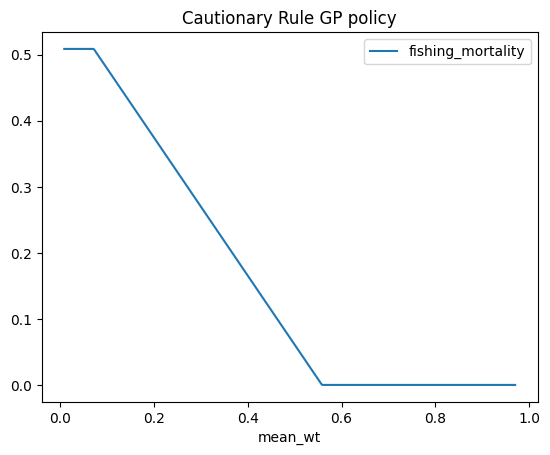

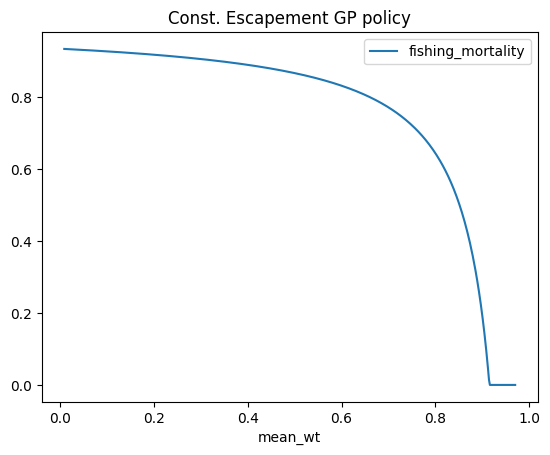

In [10]:
(
    cr_gp_df.plot(x='mean_wt', y='fishing_mortality', title='Cautionary Rule GP policy'),
    esc_gp_df.plot(x='mean_wt', y='fishing_mortality', title='Const. Escapement GP policy'),

)  

In [10]:
esc_rews = eval_pol(
    policy=ConstEsc(env=AsmEnv(config=CONFIG), observed_var='mean_wt', **esc_gp_args), 
    env_cls=AsmEnv, config=CONFIG, 
    n_batches=2, batch_size=150
)

cr_rews = eval_pol(
    policy=CautionaryRule(env=AsmEnv(config=CONFIG), observed_var='mean_wt', **cr_gp_args), 
    env_cls=AsmEnv, config=CONFIG, 
    n_batches=2, batch_size=150
)

2024-04-25 17:04:35,521	INFO worker.py:1749 -- Started a local Ray instance.
2024-04-25 17:04:42,706	INFO worker.py:1749 -- Started a local Ray instance.
2024-04-25 17:04:49,645	INFO worker.py:1749 -- Started a local Ray instance.
2024-04-25 17:04:56,672	INFO worker.py:1749 -- Started a local Ray instance.


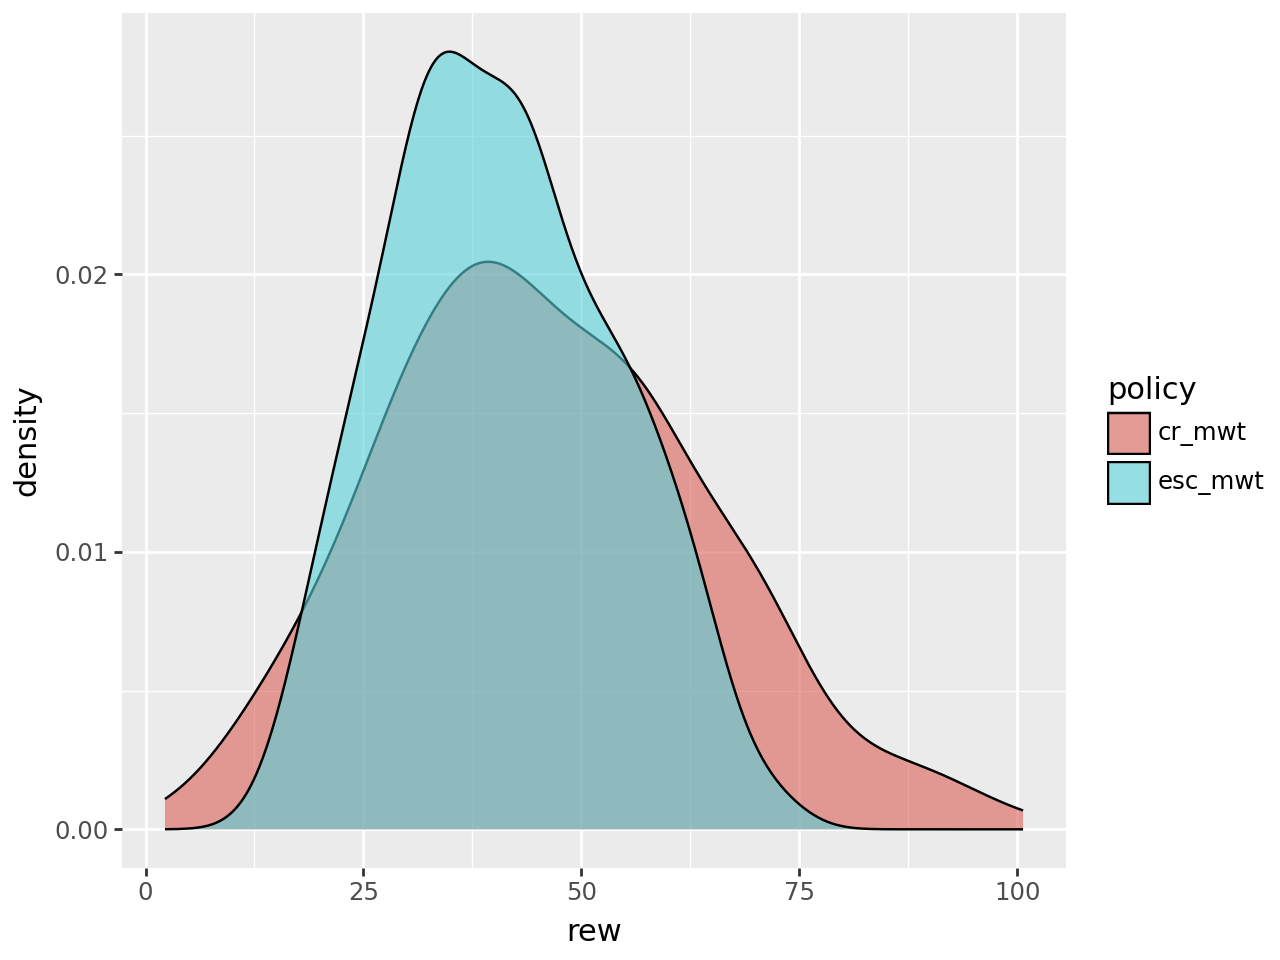

In [11]:
esc_df_mwt = pd.DataFrame({'rew': esc_rews, 'policy': ['esc_mwt' for _ in esc_rews]})
cr_df_mwt = pd.DataFrame({'rew': cr_rews, 'policy': ['cr_mwt' for _ in cr_rews]})

from plotnine import ggplot, aes, geom_density

evaluation = pd.concat([esc_df_mwt, cr_df_mwt])
ggplot(evaluation, aes(x='rew', fill='policy')) + geom_density(alpha=0.6)

In [36]:
esc_df_mwt.head()

,0
0,46.167234
1,13.035419
2,52.331254
3,18.609789
4,39.136333
